# Выбор локации для скважины

## Описание проекта

 - Компания "ГлавГосРосНефть" занимается добычей нефти. Необходимо решить, где бурить скважину
 - Для поиска скважины следует использовать следующий план:
    + В избранном регионе необходимо собрать информацию о характеристиках скважин: качество нефти и объём её запасов;
    + Построить модель для предсказания объёма запасов в новых скважинах;
    + Выбрать скважины с самыми высокими оценками значений;
    + Определить регион с максимальной суммарной прибылью отобранных скважин.

## Цели

- Определить регион, добыча нефти в котором принесёт наибольшую прибыль

## Задачи

- Построить модель под указанную цель
- Проанализировать возможную прибыль и риски техникой Bootstrap

## Описание данных

- Дано три датасета, которые содержат информацию о характеристиках скважин в соответствующих регионах. Их структура одинаковая:
    + `id` — уникальный идентификатор скважины;
    + `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
    + `product` — объём запасов в скважине (тыс. баррелей).

## План работы
    1. Загрузить и подготовить данные;
    2. Обучить и проверить модель для каждого региона;
    3. Провести подготовку данных для расчёта прибыли;
    4. Написать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели;
    5. Посчитать риски и прибыль для каждого региона;

## Условия задачи
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
- Бюджет на разработку скважин в регионе — 10 млрд рублей
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью

# Шаг 1. Загрузка и подготовка данных

- Загрузка нужных версий библиотек

In [1]:
!pip install -q scikit-learn
!pip install -q shap
!pip install -q matplotlib
!pip install -q seaborn
!pip install -q phik
!pip install -q yellowbrick


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


- Загрузка инструментов

In [2]:
# Библиотеки
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import sklearn # версия 1.4.1.post1
import phik
import shap
#Инструменты из библиотек
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder)
from sklearn.linear_model import (LogisticRegression, LinearRegression)
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.model_selection import FeatureImportances
from sklearn.inspection import permutation_importance
from phik import phik_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.metrics import (r2_score,
                             roc_auc_score,
                             confusion_matrix,
                             mean_squared_error,
                             root_mean_squared_error,
                             mean_absolute_error,
                             precision_score,
                             accuracy_score,
                             recall_score,
                             make_scorer
                            )

## 1.1 Загрузка данных

- Загрузим данные из датасетов и посмотрим их структуру

In [3]:
df_region_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', sep = ',')
df_region_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', sep = ',')
df_region_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', sep = ',')

In [4]:
df_region_set = [df_region_1, df_region_2, df_region_3]

In [5]:
df_region_set[0].head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [6]:
df_region_set[1].head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
df_region_set[2].head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [8]:
for df in df_region_set: 
    df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

### Комментарий по загрузке данных:
- Во всех датасетах отсутствуют пропуски
- Тип данных столбцов корректный
- В названиях столбцов отсутствуют орфографические ошибки, регистр тоже правильный

## 1.2 Предобработка данных

- Проанализируем, есть ли в датасетах дубликаты

In [9]:
for i in range(3):
    print(f"Количество дубликатов в датасете {i + 1} составляет: {df_region_set[i].duplicated().sum()}")

Количество дубликатов в датасете 1 составляет: 0
Количество дубликатов в датасете 2 составляет: 0
Количество дубликатов в датасете 3 составляет: 0


- Проводить дополнительные исследования в предобработке данных не имеет смысла, так как:
    + В датасете отсутствуют пропуски
    + Неявные дубликаты теряют свой смысл, потому как ошибки в написании имеющихся значений в столбцах исключены. Каждый из 5 столбцов является уникальным идентификационным номером или координатой, где неявная ошибка невозможна

## 1.3 Исследовательский анализ данных

- Посмотрим на распределение объёмов запасов нефти в скважине

In [10]:
# функция для построения гистограмм
def hist_build(df, column, hist_color, xlabel, ylabel, title, i, j, quant_of_bins, more_than_one_row):
    if more_than_one_row:
        axes[i, j].set_title(title) 
        axes[i, j].hist(df[column], bins = quant_of_bins, color = hist_color)
        axes[i, j].set_xlabel(xlabel)
        axes[i, j].set_ylabel(ylabel)
    else:
        axes[j].set_title(title) 
        axes[j].hist(df[column], bins = quant_of_bins, color = hist_color)
        axes[j].set_xlabel(xlabel)
        axes[j].set_ylabel(ylabel)     

In [11]:
# Функция для построения ящиков с усами
def boxplot_build(df, column, xlabel, title, i, j, left_lim, right_lim):
    axes[i, j].boxplot(df[[column]], vert = False)
    axes[i, j].set_title(title) 
    axes[i, j].set_xlabel(xlabel)
    axes[i, j].set_xlim(left_lim, right_lim)

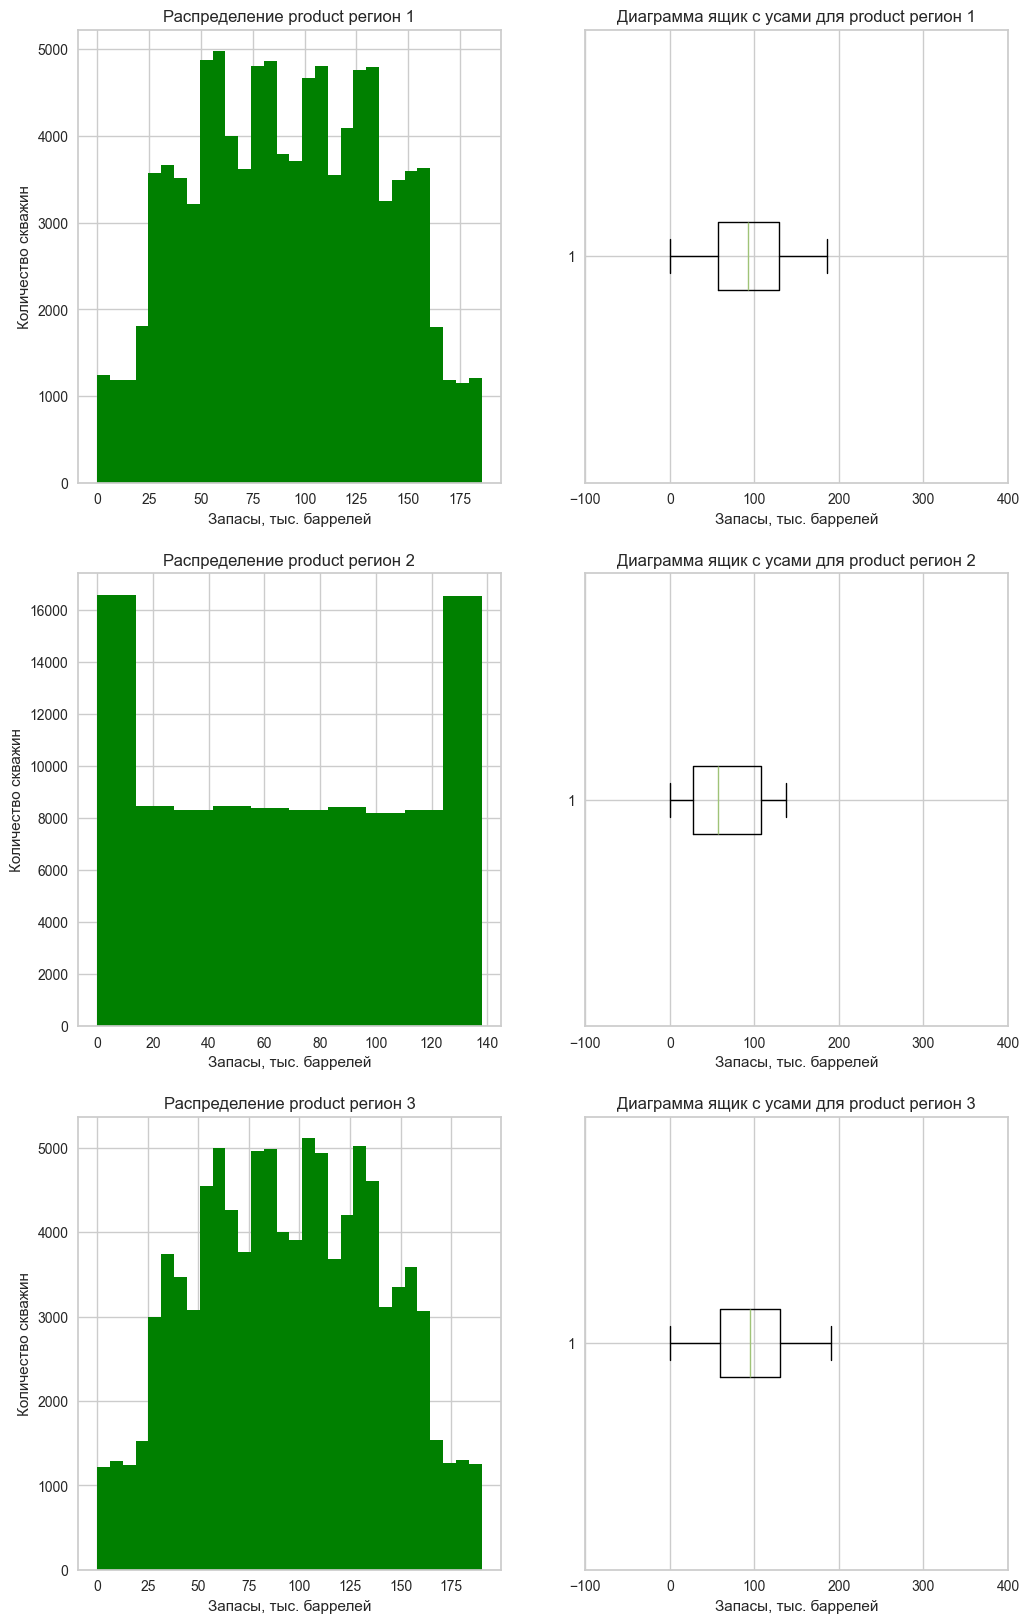

In [12]:
#num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
param_quant_of_bins = [30, 10, 30]
param_lim_left = [-100, -100, -100]
param_lim_right = [400, 400, 400]
region_names = ['регион 1', 'регион 2', 'регион 3',]

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 20))
for i in range(3):
    hist_build(df_region_set[i],
               'product',
               'green',
               'Запасы, тыс. баррелей',
               'Количество скважин',
               'Распределение ' + 'product ' + region_names[i],
               i,
               0,
               param_quant_of_bins[i],
               True
              )
    
    boxplot_build(df_region_set[i],
                  'product',
                  'Запасы, тыс. баррелей',
                  'Диаграмма ящик с усами для ' + 'product ' + region_names[i],
                  i,
                  1,
                  param_lim_left[i],
                  param_lim_right[i]       
                 )

In [13]:
for i in range(3):
    print(f"Описание запасов {region_names[i]}:")
    print(df_region_set[i]['product'].describe())
    print('\n')

Описание запасов регион 1:
count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


Описание запасов регион 2:
count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


Описание запасов регион 3:
count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64




- В регионах 1 и 3 распредление запасов нефти одинаковое и имеет вид нормального распредления
- В регионе 2 распределение объёмов запасов нефти по скважинам специфическое. Больше всего скважин приходится на скважины с малыми запасами нефти или чрезвычайно большими относительно среднего уровня запасов
- Описание запасов показало, что медианное значение запасов для регионов 1 и 3 является примерно одинаковым (91 и 94 тыс. баррелей соответственно). В то время как в регионе 2 этот показатель составляет 57 тыс. баррелей
- Для других столбцов проводить исследовательский анализ данных не имеет смысла

## 1.4 Корреляционный анализ данных

- Построим матрицу корреляции, чтобы выяснить, какой из показателей оказывает наибольшее влияние на целевой признак(product)
- Воспользуемся матрицей Спирмена, т.к. неизвестно, что обозначают признаки f0, f1, f2, а также отсутствует информация об их распределении
- Матрицы построим сразу для трёх регионов, 
- Предварительно отбросим столбец `id`, чтобы он не вносил ошибок при расчёте коэффициента корреляции

In [14]:
for i in range(3):
    df = df_region_set[i].drop('id', axis = 1)
    print(df.head())

         f0        f1        f2     product
0  0.705745 -0.497823  1.221170  105.280062
1  1.334711 -0.340164  4.365080   73.037750
2  1.022732  0.151990  1.419926   85.265647
3 -0.032172  0.139033  2.978566  168.620776
4  1.988431  0.155413  4.751769  154.036647
          f0         f1        f2     product
0 -15.001348  -8.276000 -0.005876    3.179103
1  14.272088  -3.475083  0.999183   26.953261
2   6.263187  -5.948386  5.001160  134.766305
3 -13.081196 -11.506057  4.999415  137.945408
4  12.702195  -8.147433  5.004363  134.766305
         f0        f1        f2     product
0 -1.146987  0.963328 -0.828965   27.758673
1  0.262778  0.269839 -2.530187   56.069697
2  0.194587  0.289035 -5.586433   62.871910
3  2.236060 -0.553760  0.930038  114.572842
4 -0.515993  1.716266  5.899011  149.600746


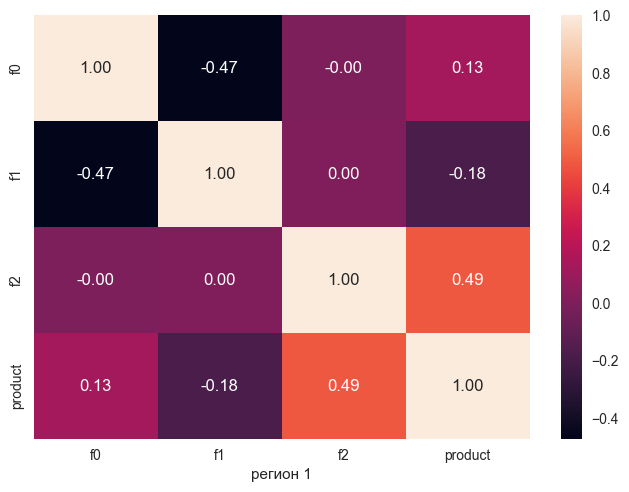

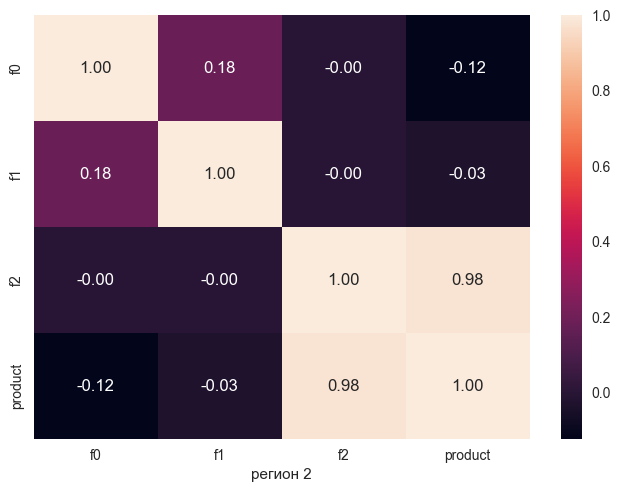

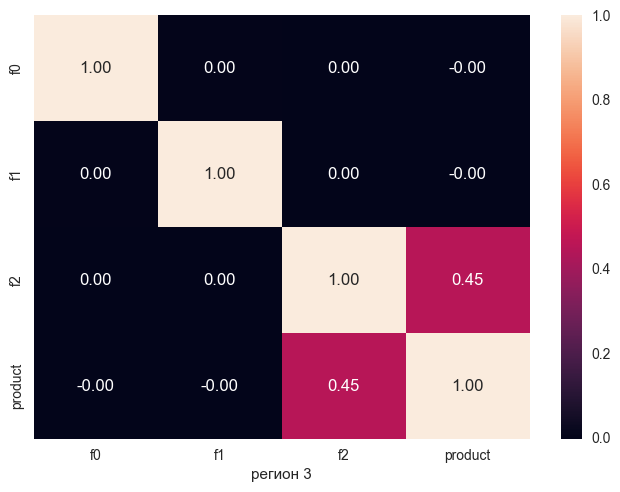

In [15]:
#fig, axes = plt.subplots(ncols = 1, nrows = 3, figsize = (12, 21));
for i in range(3):
    df = df_region_set[i].drop('id', axis = 1)
    plt.show()
    ax = sns.heatmap(df.corr(method = "spearman"), annot = True, fmt = ".2f");
    ax.set(xlabel = region_names[i])

- Для региона 1 наибольшее влияние на целевой признак оказывает `f2`(0.49)
- У региона 2 очень высокая корреляция признака `f1` с целевым признаком `product`(0.98)
- Для региона 3 ситуация похожая на случай с регионом 1. Корреляция признака `f2` с целевым признаком составляет 0.45

### Выводы по загрузке и обработке данных:
- В датасетах не было обнаружено ошибок в написании названий столбцов, структуре и типах данных столбцов
- Распределение целевого признака для каждого из регионов соответствует здравому смыслу. Для регионов 1 и 3 распределения качественно имеют одинаковый вид, в то время как для региона 2 оно отличное.
- Средние значения целевого признака у регионов 1 и 3 также имеют практически одинаковые значения, как и влияние входных признаков на целевой имеет схожий характер. У региона 2 ситуация специфическая, её можно наблюдать на матрице корреляции, а также при описании целевого признака

# Шаг 2. Обучение и проверка модели для каждого из регионов

- Целевой признак является количественным, поэтому потенциально можно использовать в качестве моделей линейную регрессию и дерево решений
- Входных признаков не так уж много, более того они все являются количественными, поэтому использование дерева решений вряд ли даст хорошие результаты
- Также необходимо заметить, что у входных признаков для каждого из регионов присутствует хотя бы 1 признак, которые обладает существенным значением корреляции с целевым признаком
- Поэтому целесообразно применить модель линейной регрессии(как и рекомендуется в условии задачи)

## 2.1 Разбиение данных

- Разбиение данных проведём на обучающую и валидационную выборку в соотношении 75:25

In [16]:
input_cols = ['f0', 'f1', 'f2']
target = ['product']
RANDOM_STATE = 77

In [17]:
X = [[],[],[]]
y = [[],[],[]]
X_train = [[],[],[]]
X_valid = [[],[],[]]
y_train = [[],[],[]]
y_valid = [[],[],[]]
predictions = [[],[],[]]

In [18]:
def split_input_and_target(df, input_cols, target):
    return(df[input_cols], df[target])

In [19]:
for i in range(3):
    X[i], y[i] = split_input_and_target(df_region_set[i], input_cols, target)
    X_train[i], X_valid[i], y_train[i], y_valid[i] = train_test_split(X[i],y[i], test_size = 0.25, random_state = RANDOM_STATE )        

## 2.2 - 2.5 Обучение модели и анализ результатов

- Обучим модель для каждого региона и сделаем предсказания на валидационной выборке

In [20]:
#Создание переменных, отвечающих за хранение отмасштабированных данных, скейлеров и самих моделей 
X = [[],[],[]]
y = [[],[],[]]
X_train_scaled = [[],[],[]]
X_valid_scaled = [[],[],[]]
scaler = [[],[],[]]
model_lr = [[],[],[]]

In [21]:
for i in range(3):
# Подготовка признаков - масштабирование и кодирование
    scaler[i] = StandardScaler()
    X_train_scaled[i] = scaler[i].fit_transform(X_train[i])
    X_valid_scaled[i] = scaler[i].transform(X_valid[i])

    X_train_scaled[i] = pd.DataFrame(X_train_scaled[i], columns = input_cols)
    X_valid_scaled[i] = pd.DataFrame(X_valid_scaled[i], columns = input_cols)
# Обучение моделей
    model_lr[i] = LinearRegression()
    model_lr[i].fit(X_train_scaled[i], y_train[i])
    predictions[i] = model_lr[i].predict(X_valid_scaled[i])
# Результаты работы моделей:
    print(f'Значение метрики RMSE - {region_names[i]} : {root_mean_squared_error(y_valid[i], predictions[i]).round(3)}')
    print(f'Среднее значение запасов сырья фактически : {np.mean(y_valid[i]).round(3)} тыс. баррелей')
    print(f'Среднее значение предсказанных запасов сырья : {np.mean(predictions[i]).round(3)} тыс. баррелей')

Значение метрики RMSE - регион 1 : 37.772
Среднее значение запасов сырья фактически : 92.525 тыс. баррелей
Среднее значение предсказанных запасов сырья : 92.608 тыс. баррелей
Значение метрики RMSE - регион 2 : 0.889
Среднее значение запасов сырья фактически : 69.121 тыс. баррелей
Среднее значение предсказанных запасов сырья : 69.119 тыс. баррелей
Значение метрики RMSE - регион 3 : 39.931
Среднее значение запасов сырья фактически : 94.874 тыс. баррелей
Среднее значение предсказанных запасов сырья : 95.009 тыс. баррелей


- Добавим предсказания в валидационную выборку, а также объединим входные и целевой признаки валидационной выборки

In [22]:
df_valid = [[], [], []]

In [23]:
for i in range(3):
    df_valid[i] = X_valid[i].join(y_valid[i])
    df_valid[i]['predictions'] = predictions[i]
    print(df_valid[i].head())

             f0        f1        f2     product  predictions
47770 -0.263714  0.761007  1.527840   78.457075    75.950843
60076  1.895585  0.138823  2.169471   81.490366    97.225399
48414  0.864023 -0.371282  6.439782  155.905578   128.650402
23216  1.053974 -0.552166  3.258744  140.785031   110.968969
57805  0.756235 -0.378856  4.360853  177.124963   114.644157
             f0        f1        f2     product  predictions
47770 -1.470958 -0.088960  3.004893   84.038886    82.857921
60076 -8.083431 -0.774358  5.002803  137.945408   137.679388
48414 -8.208432  0.604173  2.995995   84.038886    83.580572
23216  2.221330 -8.969547  0.992218   26.953261    28.266370
57805  5.340852 -2.424928  0.997568   26.953261    27.818314
             f0        f1        f2     product  predictions
47770  1.428705  1.365357  3.658585   73.113916   101.643034
60076 -0.346625  1.735493  4.872970  151.916189   108.601880
48414 -1.010814 -0.006276 -0.702840   95.816284    76.750084
23216  0.343575  0.19788

- По результатам работы модели видно, что достаточно точные предсказания получены для региона 2
- Для регионов 1 и 3 предсказания существенно хуже из - за отсутствия сильно коррелирующих входных признаков с целевым

# Шаг 3. Расчёт прибыли

## 3.1 Инициализация ключевых переменных

In [24]:
BUDGET = 10 ** 10 # рублей - затраты
PRICE_THSND_BARR = 4.5 * (10 ** 5) # стоимость 1 тыс. барр. в рублях
K = 200 # число скважин

## 3.2 Расчёт достаточного объёма сырья для безубыточной разработки

- Идея состоит в том, что должно выполняться условие:
    $ прибыль - затраты = 0 $
- При этом прибыль рассчитывается, как:
    $прибыль = стоимость.тыс.барр * число.тыс.барр * число.скважин$
- Выразим нужное число тыс.баррелей:
    $число.тыс.барр = затраты / (стоимость.тыс.барр * число.скважин)$

In [25]:
quant_barr = BUDGET / (PRICE_THSND_BARR * K)
print(f"Для безубыточной разработки требуется минимум {round(quant_barr,3)} тыс. баррелей для одной скважины")

Для безубыточной разработки требуется минимум 111.111 тыс. баррелей для одной скважины


- Сравнивая минимальное значение запасов сырья в одной скважине для безубыточной разработки со средними значениями в регионах, можно заключить:
    + Наиболее перспективными регионами являются 1 и 3, так как там средний показатель запасов сырья в скважинах достаточно близок(92 и 94 тыс. баррелей) к необходимому (111 тыс. баррелей)
    + При этом в регионе 2 средний показатель намного меньше и составляет 69 тыс. баррелей, что более, чем в 1.5 раза меньше требуемого значения
    + Таким образом, для разработки скважин целесообразно рассматривать регионы 1 и 3

## 3.3 Выводы по этапу подготовки расчёта прибыли

- Исходя из затрат в виде 10 млрд. рублей на 200 скважин при стоимости 450 тыс. рублей 1 тыс. баррелей было получено, что для безубыточной разработки необходимо, чтобы каждая скважина давала около 111 тыс. баррелей сырья
- Наиболее подходящими под этот критерий являются регионы 1 и 3, регион 2 обладает слишком низким средним уровнем сырья в скважинах. Следовательно, вероятность отыскать скважины с нужным количеством нефти в регионах 1 и 3 выше, чем в регионе 2.

# Шаг 4. Функция для расчёта прибыли

- Функция будет получать на вход информацию о случайных 500 скважинах
- Необходимо выбрать 200 лучших скважин по предсказанному количеству сырья, а затем посчитать для них прибыль по реальным запасам нефти

In [26]:
def profit(df):
    # Сортировка предсказанных значений сырья от большего к меньшему 
    df_ord = df.sort_values(by = 'predictions', ascending = False)
    #Выборка из 200 лучших скважин
    df_ord_top_200 = df_ord.head(K)
    #Суммирование запасов лучших 200 скважин
    general_oil_reserves = df_ord_top_200['product'].sum()
    #Расчёт прибыли
    profit = general_oil_reserves * PRICE_THSND_BARR - BUDGET
    
    return profit

- Требуемая функция реализована

# Шаг 5. Риски и прибыль для каждого региона

## 5.1 Техника Bootstrap

- Создадим 1000 выборок, используя технику bootstrap

In [27]:
def bootstrap_function(df):
    state = np.random.RandomState(777)
    values = []    
    for i in range(1000):
        subsample = df.sample(frac = 500/len(df['predictions']), replace = True, random_state = state)
        values.append(profit(subsample))
    return values

## 5.2 Средняя прибыль и 95%-й доверительный интервал

- Поиск средней прибыли и 95%-го доверительного интервала для каждого из трёх регионов после использования техники bootstrap

In [28]:
data = [[], [], []]
for i in range(3):
    data[i] = bootstrap_function(df_valid[i])
    data[i] = pd.Series(data[i])
    print(f"Регион {i + 1}:")
    print(f"Средняя прибыль в регионе: {((data[i].mean()) / (10 ** 9)).round(4)} млрд. рублей")
    (
    print("95%-й доверительный интервал прибыли составляет промежуток от",
    ((data[i].quantile(0.025))/(10 ** 9)).round(4), "до", ((data[i].quantile(0.975))/(10 ** 9)).round(4), "млрд. рублей")
    )
    print('Риск убытков равен',round((data[i] < 0).mean() * 100, 2), '%')

Регион 1:
Средняя прибыль в регионе: 0.438 млрд. рублей
95%-й доверительный интервал прибыли составляет промежуток от -0.0471 до 0.9165 млрд. рублей
Риск убытков равен 3.6 %
Регион 2:
Средняя прибыль в регионе: 0.5032 млрд. рублей
95%-й доверительный интервал прибыли составляет промежуток от 0.1206 до 0.9138 млрд. рублей
Риск убытков равен 0.4 %
Регион 3:
Средняя прибыль в регионе: 0.3682 млрд. рублей
95%-й доверительный интервал прибыли составляет промежуток от -0.2026 до 0.9088 млрд. рублей
Риск убытков равен 9.2 %


## 5.3 Выводы

- Несмотря на то что каждый этап проекта указывал на то, что оптимальными регионами для выбора разработки скважин являются 1 и 3, моделирование техникой bootstrap показало иную ситуацию
- Средняя прибыль у региона 2 оказалась выше(0.5 млрд.), чем у регионов 1(0.44 млрд.) и 3(0.37 млрд.)
- В 95% - ом доверительном интервале полностью положительная прибыль только у региона 2, в то время как у регионов 1 и 3 нижняя граница прибыли является отрицательной
- Также в регионах 1 и 3 риски убыточности разработки скважин кратно выше (3.6% и 9.2% соответственно), а в регионе 2 всего лишь 0.4%
- Таким образом, резюмируя проведённое исследование и вышеуказанные характеристики, целесообразно проводить разработку скважин в регионе 2.